<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/TIGER_%EB%AA%A8%EB%A9%98%ED%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import FinanceDataReader as fdr
import re
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
etfs = fdr.StockListing('ETF/KR')

In [4]:
rep_etfs = etfs[etfs['Name'].str.contains("TIGER", case=False)]


In [5]:
import concurrent.futures

# ==============================
# 1. 기본 설정
# ==============================
symbols = rep_etfs['Symbol'].tolist()  # 대표 ETF 리스트

start_date = (datetime.datetime.today() - pd.DateOffset(months=120)).strftime('%Y-%m-%d')
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# ==============================
# 2. 데이터 조회 함수 (월초/월말 포함)
# ==============================
def fetch_monthly_data(sym, start, end):
    try:
        df = fdr.DataReader(sym, start=start, end=end)[['Open', 'Close']]
        df_monthly = pd.DataFrame({
            f'{sym}_Open': df['Open'].resample('MS').first(),  # 월초 시가
            f'{sym}_Close': df['Close'].resample('ME').last()   # 월말 종가
        })
        return df_monthly
    except Exception as e:
        print(f"{sym} 조회 실패: {e}")
        return None

# ==============================
# 3. 병렬 처리
# ==============================
all_data_list = []

max_workers = 8  # CPU 코어 수나 네트워크 상황에 맞게 조절
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_monthly_data, sym, start_date, end_date): sym for sym in symbols}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_data_list.append(result)

0043B0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0043B0?period1=1443225600&period2=1758844800&interval=1d&includeAdjustedClose=true
0052D0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0052D0?period1=1443225600&period2=1758844800&interval=1d&includeAdjustedClose=true
0072R0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0072R0?period1=1443225600&period2=1758844800&interval=1d&includeAdjustedClose=true
0094K0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0094K0?period1=1443225600&period2=1758844800&interval=1d&includeAdjustedClose=true
0047A0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0047A0?period1=1443225600&period2=1758844800&interval=1d&includeAdjustedClose=true
0060H0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.

In [6]:
monthly_merged = pd.concat(all_data_list, axis=1)

# 월초 시가 / 월말 종가 분리
monthly_open = monthly_merged.filter(like='_Open').rename(columns=lambda x: x.replace('_Open',''))
monthly_close = monthly_merged.filter(like='_Close').rename(columns=lambda x: x.replace('_Close',''))

# 인덱스 변환 및 검증
monthly_open.index = pd.to_datetime(monthly_open.index, errors='coerce')
monthly_close.index = pd.to_datetime(monthly_close.index, errors='coerce')
assert monthly_open.index.equals(monthly_close.index), "Index mismatch between open and close"

In [13]:
# Combine monthly_open and monthly_close into monthly_price using combine
# We'll use the first non-NaN value at each position.
monthly_price = monthly_open.combine_first(monthly_close)

In [7]:
def momentum_backtest(monthly_price, etfs=None, use_filtered=False,
                      N_momentum=12, top_n=3):
    """
    monthly_price : DataFrame (컬럼=Symbol, 값=가격)
    etfs : DataFrame (Symbol, Name 포함)
    use_filtered : True면 레버리지/인버스/커버드콜/혼합 종목 제외
    """

    # ✅ 필터링 옵션
    if use_filtered and etfs is not None:
        exclude_pattern = "레버리지|인버스|2X|커버드콜|혼합"
        exclude_symbols = etfs[etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
        monthly_price = monthly_price.drop(columns=[c for c in monthly_price.columns if c in exclude_symbols])

    monthly_price = monthly_price.sort_index()

    # 월말 종가만 추출
    month_end = monthly_price.resample('M').last()

    # N개월 모멘텀 계산
    momentum = month_end.pct_change(N_momentum)

    results = []

    for i in range(N_momentum, len(month_end)-1):
        mom = momentum.iloc[i]
        top_symbols = mom.nlargest(top_n).index
        top_scores = mom[top_symbols]

        # 익월 월초~말일 수익률 계산
        next_month_idx = month_end.index[i+1]
        next_month_start = monthly_price.loc[monthly_price.index >= next_month_idx.replace(day=1)].iloc[0]
        next_month_end = month_end.iloc[i+1]

        returns = (next_month_end[top_symbols] - next_month_start[top_symbols]) / next_month_start[top_symbols]
        portfolio_return = returns.mean()

        results.append({
            'Month': next_month_idx.strftime('%Y-%m'),
            'Selected': list(top_symbols),
            'Momentum': list(top_scores.round(4)),
            'NextMonthReturn': list(returns.round(4)),
            'PortfolioReturn': round(portfolio_return, 4)
        })

    monthly_results = pd.DataFrame(results)
    cumulative_returns = (1 + monthly_results['PortfolioReturn']).cumprod()

    return monthly_results, cumulative_returns


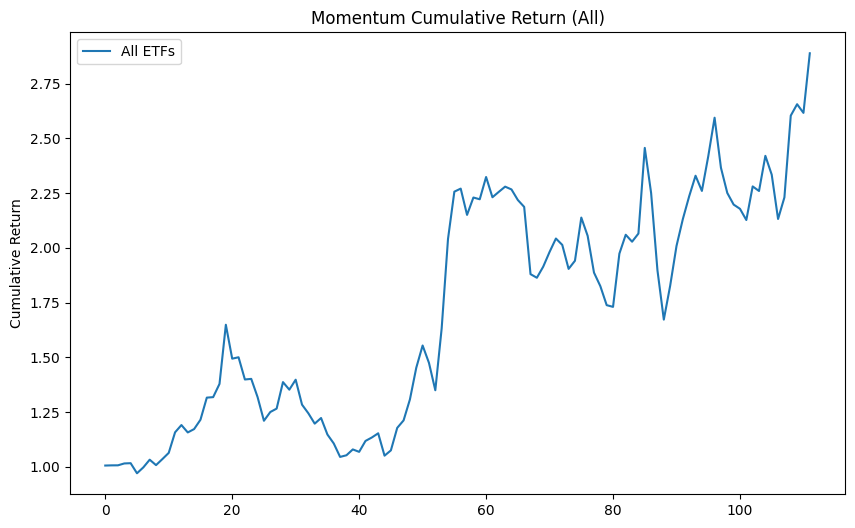

In [14]:
# (1) 전체 ETF
monthly_results_all, cum_ret_all = momentum_backtest(
    monthly_price=monthly_price,
    etfs=etfs,
    use_filtered=False,   # 필터 안 함
    N_momentum=8,
    top_n=6
)

# (2) 필터된 ETF만
"""
monthly_results_filtered, cum_ret_filtered = momentum_backtest(
    monthly_price=monthly_price,
    etfs=etfs,
    use_filtered=True,    # 필터 적용
    N_momentum=6,
    top_n=5
)
"""
# 📊 누적 수익률 비교 시각화
plt.figure(figsize=(10,6))
cum_ret_all.plot(label="All ETFs")
#cum_ret_filtered.plot(label="Filtered ETFs")
plt.title("Momentum Cumulative Return (All)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [ ]:
from itertools import product

def momentum_sweep_N_topn_top3_bottom3(monthly_price, etfs=None, use_filtered=False,
                                       N_list=range(3,13), top_n_list=range(3,8)):
    sweep_results = []
    cumulative_dict = {}

    # 모든 조합 백테스트
    for N, top_n in product(N_list, top_n_list):
        monthly_results, cum_ret = momentum_backtest(
            monthly_price=monthly_price,
            etfs=etfs,
            use_filtered=use_filtered,
            N_momentum=N,
            top_n=top_n
        )
        cumulative_dict[(N, top_n)] = cum_ret
        final_cum_ret = cum_ret.iloc[-1]
        sweep_results.append({'MomentumPeriod': N, 'TopN': top_n, 'FinalCumulativeReturn': final_cum_ret})

    sweep_results = pd.DataFrame(sweep_results)

    # 상위 3개, 하위 3개 조합 선택
    top3 = sweep_results.nlargest(3, 'FinalCumulativeReturn')
    bottom3 = sweep_results.nsmallest(3, 'FinalCumulativeReturn')
    selected_keys = list(top3[['MomentumPeriod','TopN']].itertuples(index=False, name=None)) + \
                    list(bottom3[['MomentumPeriod','TopN']].itertuples(index=False, name=None))

    # 그래프
    plt.figure(figsize=(12,6))
    for key in selected_keys:
        cum_ret = cumulative_dict[key]
        label = f'N={key[0]}, top_n={key[1]}'
        cum_ret.plot(label=label)
    plt.title('Top 3 & Bottom 3 Momentum Period & TopN Combinations')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

    return sweep_results, cumulative_dict

In [ ]:
# 전체 ETF 대상 스윕
results_all, cum_dict_all = momentum_sweep_N_topn_top3_bottom3( monthly_price=monthly_price, etfs=etfs, use_filtered=False)

# 필터된 ETF 대상 스윕
results_filtered, cum_dict_filtered = momentum_sweep_N_topn_top3_bottom3(monthly_price=monthly_price,etfs=etfs, use_filtered=True)

In [ ]:
# @title 검증용
def momentum_verification_table(monthly_price, N_momentum=12):
    """
    월말 종가 기준 N개월 모멘텀 점수와 익월 수익률 계산
    계산이 올바른지 검증할 수 있는 테이블 생성

    Parameters
    ----------
    monthly_price : pd.DataFrame
        날짜 인덱스, 종목코드 칼럼, 종가 데이터
    N_momentum : int
        모멘텀 계산 기간(개월)

    Returns
    -------
    verification_df : pd.DataFrame
        Month, Symbol, MomentumScore, NextMonthReturn, MomentumRank
    """
    monthly_price = monthly_price.sort_index()
    month_end = monthly_price.resample('M').last()
    momentum = month_end.pct_change(N_momentum)

    records = []

    for i in range(N_momentum, len(month_end)-1):
        mom = momentum.iloc[i]
        next_month_idx = month_end.index[i+1]
        next_month_start = monthly_price.loc[monthly_price.index >= next_month_idx.replace(day=1)].iloc[0]
        next_month_end = month_end.iloc[i+1]
        next_month_ret = (next_month_end - next_month_start) / next_month_start

        # 모멘텀 순위
        mom_rank = mom.rank(ascending=False)

        for symbol in monthly_price.columns:
            records.append({
                'Month': next_month_idx.strftime('%Y-%m'),
                'Symbol': symbol,
                'MomentumScore': mom[symbol],
                'MomentumRank': mom_rank[symbol],
                'NextMonthReturn': next_month_ret[symbol]
            })

    verification_df = pd.DataFrame(records)

    return verification_df

verification_df = momentum_verification_table(monthly_price, N_momentum=8)


In [ ]:
import pandas as pd

def get_next_month_portfolio_with_names(monthly_price, etfs, reference_date,
                                        N_momentum=12, top_n=3, use_filtered=False):
    """
    조회 기준 월말 모멘텀으로 익월 포트폴리오 종목(Symbol + Name) 반환
    (필터 옵션 포함)

    Parameters
    ----------
    monthly_price : pd.DataFrame
        날짜 인덱스, 종목코드 칼럼, 종가 데이터
    etfs : pd.DataFrame
        Symbol, Name 컬럼 포함 ETF 정보
    reference_date : str or pd.Timestamp
        조회 기준 날짜 (예: '2025-08-31')
    N_momentum : int
        모멘텀 계산 기간(개월)
    top_n : int
        상위 N개 종목 선정
    use_filtered : bool
        True면 레버리지/인버스/커버드콜/혼합 종목 제외

    Returns
    -------
    pd.DataFrame
        Symbol, Name 포함 익월 포트폴리오 종목
    """
    monthly_price = monthly_price.sort_index()

    # ✅ 필터링 적용
    if use_filtered:
        exclude_pattern = "레버리지|인버스|2X|커버드콜|혼합"
        exclude_symbols = etfs[etfs['Name'].str.contains(exclude_pattern, regex=True)]['Symbol'].tolist()
        monthly_price = monthly_price.drop(columns=[c for c in monthly_price.columns if c in exclude_symbols])

    month_end = monthly_price.resample('M').last()

    reference_date = pd.to_datetime(reference_date)
    month_key = month_end.index[month_end.index <= reference_date][-1]

    # 모멘텀 계산
    if month_end.index.get_loc(month_key) < N_momentum:
        raise ValueError(f"N_momentum={N_momentum}개월 모멘텀 계산 불가 (데이터 부족).")

    momentum = month_end.pct_change(N_momentum)
    mom = momentum.loc[month_key]

    # 상위 N개 종목 선정
    top_symbols = mom.nlargest(top_n).index.tolist()

    # Symbol → Name 매핑 (누락 방지용 reindex 사용)
    top_df = etfs.set_index('Symbol').reindex(top_symbols).reset_index()

    return top_df

In [ ]:
# 전체 ETF 기준
top_portfolio_all = get_next_month_portfolio_with_names(
    monthly_price=monthly_price,
    etfs=etfs,
    reference_date="2025-08-31",
    N_momentum=8,
    top_n=6,
    use_filtered=False
)

In [ ]:
# 필터 적용 (롱온리 중심)
top_portfolio_filtered = get_next_month_portfolio_with_names(
    monthly_price=monthly_price,
    etfs=etfs,
    reference_date="2025-08-31",
    N_momentum=11,
    top_n=5,
    use_filtered=True)

In [ ]:
top_portfolio_filtered